# Spot Price Forecasting

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# import data
df = pd.read_csv('data_NO2.csv', sep=';')
df.head()

,datetime_utc,volume_demand,volume_production,spot_price
0,2015-12-31 23:00:00+00:00,4043.0,7818.0,16.39
1,2016-01-01 00:00:00+00:00,4010.0,7694.0,16.04
2,2016-01-01 01:00:00+00:00,3930.0,7437.0,15.74
3,2016-01-01 02:00:00+00:00,3839.0,7120.0,15.57
4,2016-01-01 03:00:00+00:00,3833.0,7041.0,15.47


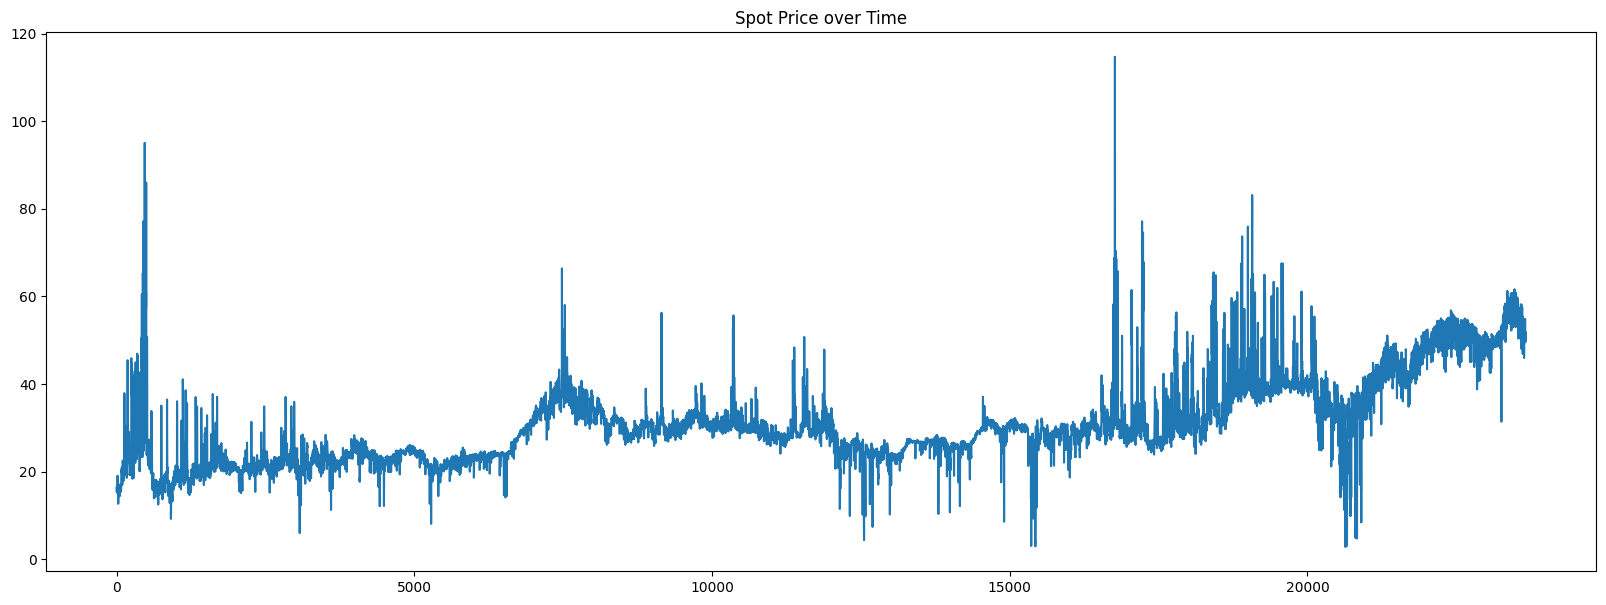

In [4]:
plt.figure(figsize=(20,7))
plt.plot(df.spot_price)
plt.title('Spot Price over Time')
plt.show()

### ARDRegression Scikitlearn

In [47]:
df_processed = pd.read_csv('data_NO2_processed.csv', sep=';')
df_processed = df_processed.drop(['volume_production_rolling', 'volume_demand_rolling', 'target'], axis=1)
df_processed.head()

,volume_demand,volume_production,spot_price,year,month,week,day,hour,dayofweek,weekend,working_hours,night,morning,afternoon,evening,delta
0,4043.0,7818.0,16.39,2015,12,53,31,23,3,0,0,0,0,0,1,3775.0
1,4010.0,7694.0,16.04,2016,1,53,1,0,4,0,0,1,0,0,0,3684.0
2,3930.0,7437.0,15.74,2016,1,53,1,1,4,0,0,1,0,0,0,3507.0
3,3839.0,7120.0,15.57,2016,1,53,1,2,4,0,0,1,0,0,0,3281.0
4,3833.0,7041.0,15.47,2016,1,53,1,3,4,0,0,1,0,0,0,3208.0


In [51]:
from scipy import stats

df_processed['price_boxcox'], lam = stats.boxcox(df_processed['spot_price'])
df_processed['price_stationary'] = df_processed['price_boxcox'].diff()
df_processed.dropna(inplace=True)
# df_processed.head()

In [52]:
y_train = df_processed['price_stationary'].iloc[:-int(len(df_processed)*0.2)]
X_train = df_processed.iloc[:-int(len(df_processed)*0.2)].drop(['price_stationary'], axis=1)
y_test = df_processed['price_stationary'].iloc[-int(len(df_processed)*0.2):]
X_test = df_processed.iloc[-int(len(df_processed)*0.2):].drop(['price_stationary'], axis=1)

# y_train = df_processed['spot_price'].iloc[:-int(len(df_processed)*0.2)]
# X_train = df_processed.iloc[:-int(len(df_processed)*0.2)].drop(['spot_price'], axis=1)
# y_test = df_processed['spot_price'].iloc[-int(len(df_processed)*0.2):]
# X_test = df_processed.iloc[-int(len(df_processed)*0.2):].drop(['spot_price'], axis=1)

In [53]:
from sklearn.linear_model import ARDRegression

model = ARDRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
from scipy.special import inv_boxcox
import plotly.graph_objects as go

boxcox_forecasts_ard = []
for idx in range(len(X_test)):
    if idx == 0:
        boxcox_forecast_ard = predictions[idx] + X_train['price_boxcox'].iloc[-1]
    else:
        boxcox_forecast_ard = predictions[idx] + boxcox_forecasts_ard[idx-1]

    boxcox_forecasts_ard.append(boxcox_forecast_ard)

forecasts = inv_boxcox(boxcox_forecasts_ard, lam)

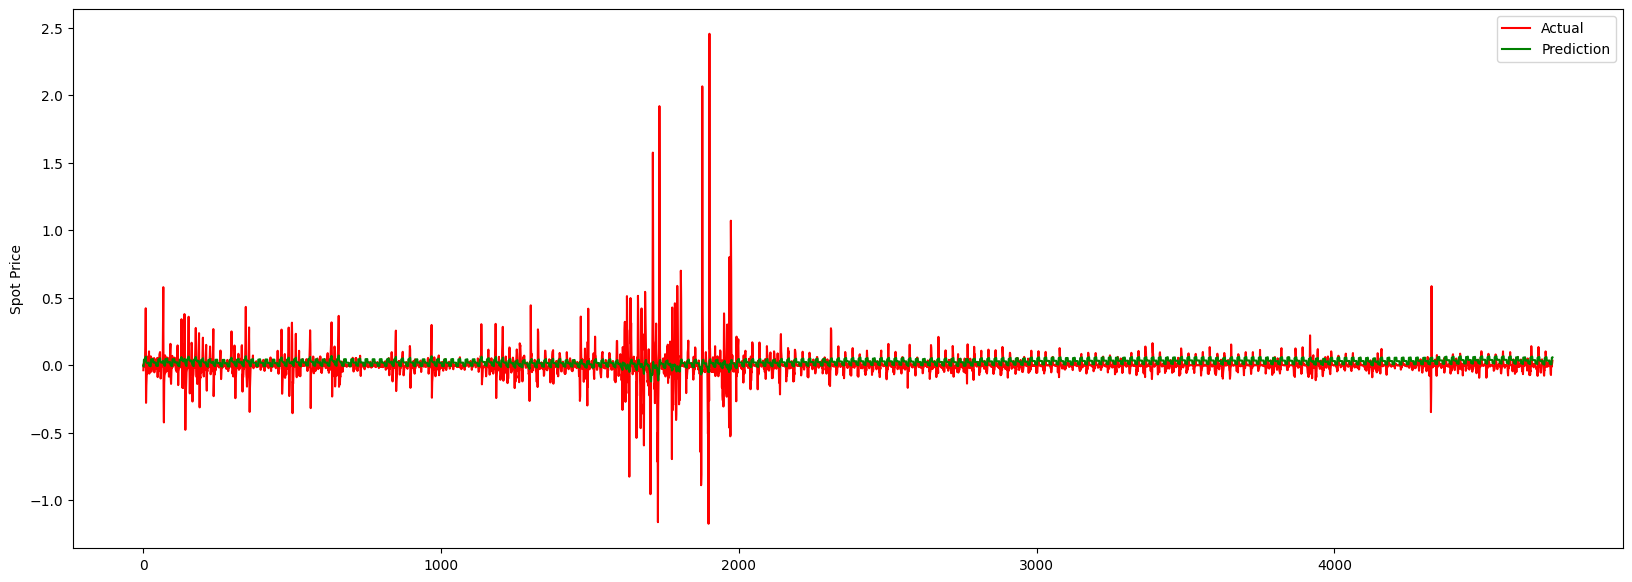

In [54]:
plt.figure(figsize=(20,7))
plt.plot(list(y_test), 'r')
plt.plot(predictions, 'g')
plt.legend(['Actual', 'Prediction'])
plt.ylabel('Spot Price')
plt.show()

### Statsmodel - Autoregression

In [5]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

##### Autocorrelation plot:
- significant spikes at regular intervals --> seasonality (or periodic patterns)
- if the values of the acf decreas slowly --> trend in the data
- if the ACF decreases slowly and doesn’t cut off quickly --> indicates that the series is non-stationary and may need differencing to make it stationary.
- if most of the ACF values are positive --> indicates positive autocorrelation where high values follow high values, and low values follow low values.

In [6]:
# Autoregression model

# make target stationary
df['price_boxcox'], lam = stats.boxcox(df['spot_price'])
df['price_stationary'] = df['price_boxcox'].diff()
df.dropna(inplace=True)
df.head()

,datetime_utc,volume_demand,volume_production,spot_price,price_boxcox,price_stationary
1,2016-01-01 00:00:00+00:00,4010.0,7694.0,16.04,3.193432,-0.028436
2,2016-01-01 01:00:00+00:00,3930.0,7437.0,15.74,3.168610,-0.024822
3,2016-01-01 02:00:00+00:00,3839.0,7120.0,15.57,3.154354,-0.014256
4,2016-01-01 03:00:00+00:00,3833.0,7041.0,15.47,3.145903,-0.008451
5,2016-01-01 04:00:00+00:00,3944.0,7246.0,15.75,3.169444,0.023541


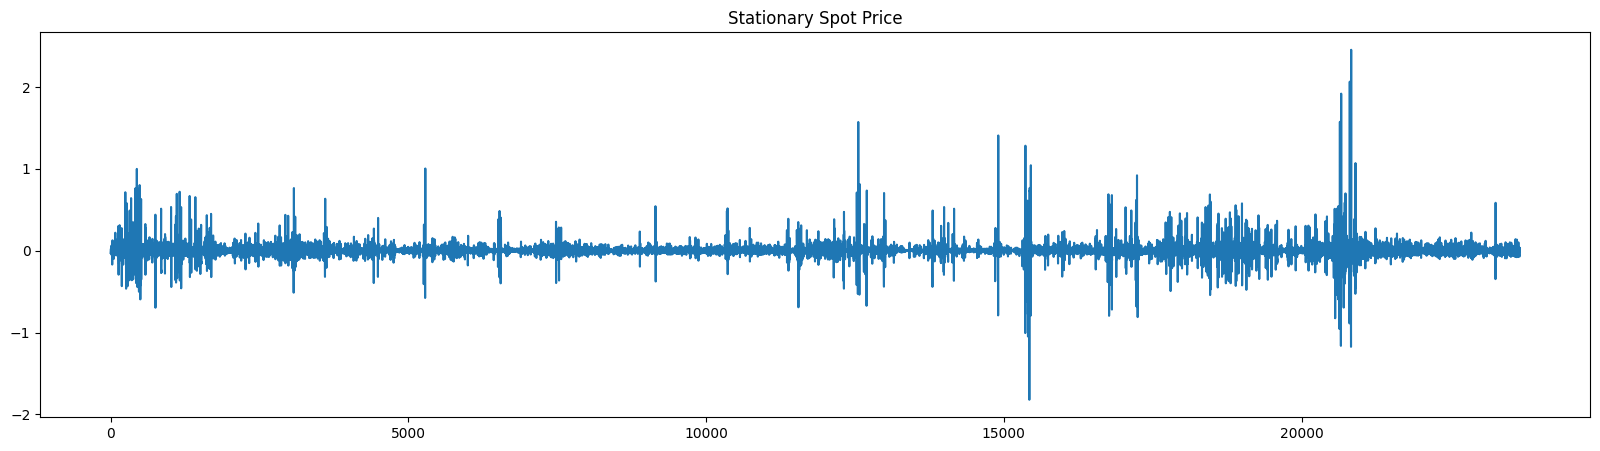

In [7]:
plt.figure(figsize=(20,5))
plt.plot(df.price_stationary)
plt.title('Stationary Spot Price')
plt.show()

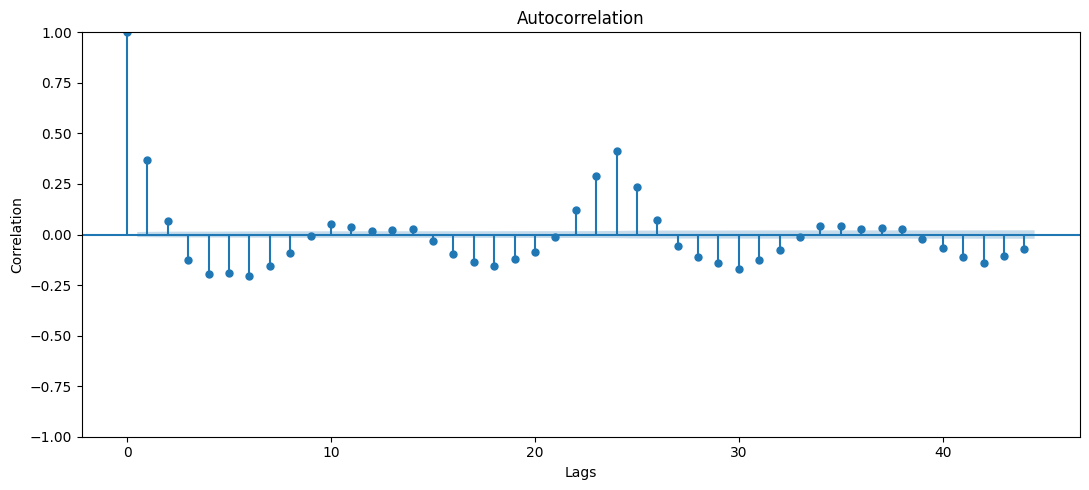

In [22]:
plt.rc('figure', figsize=(11,5))
plot_acf(df['price_stationary'])
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()

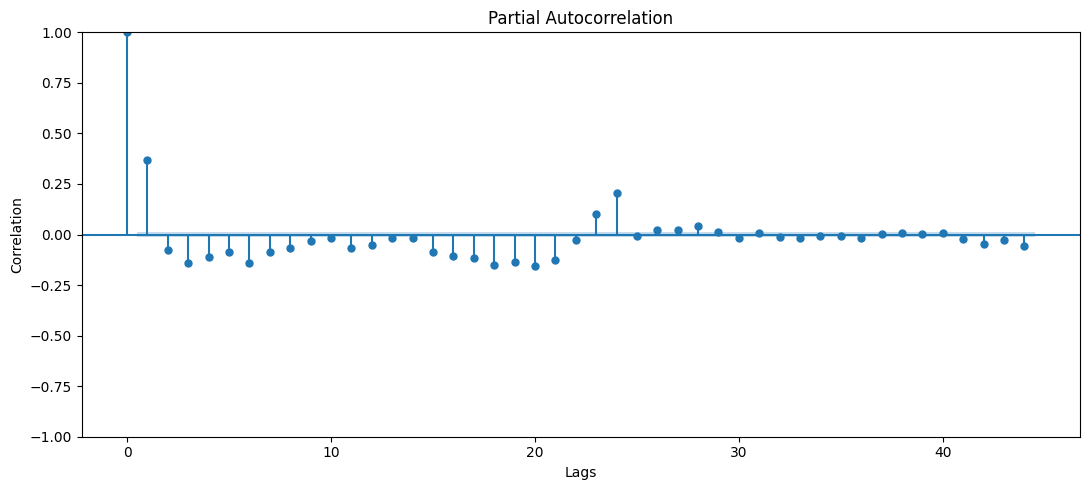

In [31]:
plt.rc('figure', figsize=(11,5))
plot_pacf(df['price_stationary'], method='ywm')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()

In [8]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
df.set_index('datetime_utc', inplace=True)

df.index = pd.DatetimeIndex(df.index).to_period('h')
df.head()

C:\Users\Marie\AppData\Local\Temp\ipykernel_4152\1007929605.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index = pd.DatetimeIndex(df.index).to_period('h')


,volume_demand,volume_production,spot_price,price_boxcox,price_stationary
datetime_utc,,,,,
2016-01-01 00:00,4010.0,7694.0,16.04,3.193432,-0.028436
2016-01-01 01:00,3930.0,7437.0,15.74,3.168610,-0.024822
2016-01-01 02:00,3839.0,7120.0,15.57,3.154354,-0.014256
2016-01-01 03:00,3833.0,7041.0,15.47,3.145903,-0.008451
2016-01-01 04:00,3944.0,7246.0,15.75,3.169444,0.023541


In [9]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Split train and test data
train = df.iloc[:-int(len(df)*0.1)]
test = df.iloc[-int(len(df)*0.1):]

selector = ar_select_order(train['price_stationary'], 25)
model = AutoReg(train['price_stationary'], lags=selector.ar_lags).fit()

In [10]:
# predict spot prices for next timesteps
nr_steps = 24
transformed_forecasts = list(model.forecast(steps=nr_steps))

In [11]:
from scipy.special import inv_boxcox
import plotly.graph_objects as go

boxcox_forecasts = []
for idx in range(nr_steps):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['price_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index.to_timestamp(), y=test['price_stationary'], name='Test'))
fig.add_trace(go.Scatter(x=test.index.to_timestamp(), y=transformed_forecasts, name='Forecast'))
fig.update_layout(template='simple_white', font=dict(size=18), title_text='Autoregression', 
                    width=950, title_x=0.5, height=400, xaxis_title='Date', yaxis_title='Spot Price')
fig.show()

In [13]:
def plot_forecasts(forecasts) -> None:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index.to_timestamp(), y=train['spot_price'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index.to_timestamp(), y=test['spot_price'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index.to_timestamp(), y=forecasts, name='Forecast'))
    fig.update_layout(template='simple_white', font=dict(size=18), title_text='Autoregression', 
                      width=950, title_x=0.5, height=400, xaxis_title='Date', yaxis_title='Spot Price')
    return fig.show()

plot_forecasts(forecasts)

#### Evaluation

In [14]:
from statsmodels.tools.eval_measures import rmse, meanabs

# calculating the root mean squared error and the mean absolute error
print(f'RMSE: ', rmse(test['spot_price'][:24], forecasts))
print(f'Mean Absolute Error: ', meanabs(test['spot_price'][:24], forecasts))

RMSE:  1.5580882557217894
Mean Absolute Error:  1.3008323334031051


### Statsmodel - ARMA

In [62]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.api as sm

In [64]:
arma_order_select_ic(df['spot_price'], ic='aic', trend='n')

c:\Users\Marie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\Marie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Marie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Marie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



{'aic':                0              1              2
 0  231707.949929  200113.196911  173760.879831
 1   95875.993260   92604.122351   92539.289901
 2   92917.663671   92563.372265   92521.262976
 3   92368.789168   90194.026262   92561.492066
 4   92128.086504   90193.261148   90202.983659,
 'aic_min_order': (4, 1)}

In [66]:
# Fit the ARMA model
# ARMA(p, q) where p is the order of the AR part and q is the order of the MA part
p, q = 4, 1  # You can change these values based on ACF and PACF plots
arma_model = ARIMA(df['spot_price'], order=(4, 1, 1)).fit()

c:\Users\Marie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\Marie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [67]:
# Print the summary of the model
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:             spot_price   No. Observations:                23665
Model:                 ARIMA(4, 1, 1)   Log Likelihood              -45079.098
Date:                Mon, 04 Nov 2024   AIC                          90170.196
Time:                        11:22:50   BIC                          90218.626
Sample:                    01-01-2016   HQIC                         90185.912
                         - 09-13-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2433      0.003    495.202      0.000       1.238       1.248
ar.L2         -0.4576      0.003   -152.529      0.000      -0.463      -0.452
ar.L3          0.0403      0.004     10.903      0.0

In [79]:
# Forecast future values
forecast_steps = 72
forecast_arma = arma_model.forecast(steps=forecast_steps)

In [80]:
fig = go.Figure()
# fig.add_trace(go.Scatter(x=test.index.to_timestamp(), y=test['price_stationary'], name='Test'))
fig.add_trace(go.Scatter(x=test.index.to_timestamp(), y=forecast_arma, name='Forecast'))
fig.update_layout(template='simple_white', font=dict(size=18), title_text='ARMA', 
                    width=950, title_x=0.5, height=400, xaxis_title='Date', yaxis_title='Spot Price')
fig.show()

## ...